In [1]:
loadpackages = function(){
  suppressMessages(require(tidyverse))
  suppressMessages(require(brms))
  suppressMessages(require(patchwork))
  suppressMessages(require(bayesplay))
  suppressMessages(require(BayesFactor))
  suppressMessages(require(logspline))
  suppressMessages(require(furrr))
  suppressMessages(require(tidyverse))
  suppressMessages(require(magrittr))
  suppressMessages(require(logspline))
  suppressMessages(require(patchwork))
  suppressMessages(require(IRdisplay))
  suppressMessages(require(broom))

}

loadpackages()

# Computing Bayes factors

We've already worked through computing a **Bayes factor** for our coin flip example. In this section, we're going to work through computing BFs for the kinds of problems you ordinarily encounter in psychology. We're going to start simple, and look at the kind of problems that you might have answered with a *t*-test. 

But before that, we need to go back to our equation for $\mathcal{M}_H$:
 
 $$\mathcal{M}_H = \sum_{i=1}^{n}\mathcal{L}_H(\theta_i|\mathbf{y})\cdot{}p(\theta_i)\cdot{}\frac{1}{n}$$   

This equation worked fine for our coin flip example. We had a discrete number of parameter values (or sub-hypotheses) so we could just average (i.e., sum and then multiply by $\frac{1}{n}$) their likelihood values. But now we're going to start working with problems where our sub-hypotheses are going to span a continuous range. So we'll just update our equation to reflect this. The equation "works" the same way, but it will look a little different. Our new equation is as follows:


$$\mathcal{M}_H = \int_{\theta\in\Theta_H}\mathcal{L}_H(\theta|\mathbf{y})p(\theta)d\theta$$

The equation still does the same thing—that is, it represents a continuous average of likelihoods, over the entire parameter space ($\Theta_H$), with the prior ($p$) serving as the weights.


## Computing Bayes factors: Part 1

We'll start with a problem that's outlined in Rouder et al (2009, pg 232). We'll work through recreating the analysis, so that we can better understand how it works and what it means. 

Rouder et al (2009) reports some summary stats from Grider and Malmberg (2008). Usually, we're not working off summary stats, so we'll use those summary stats to generate some *synthetic* data that matches those characters. 

In [2]:
# lets generate some data to work with because usually we work with raw data and not summary stats

# statistics reported by Grider and Malmberg (2008) in Rouder et al (2009, pg 232)

# reported values!
sample_size = 80
netural_words = 0.76
positive_words = 0.80
t_stat = 2.24

# calculate the rest from the reported values!
mean_of_difference = positive_words - netural_words
sd_of_difference = (mean_of_difference * sqrt(sample_size)) / t_stat

# generate some data that matches those characteristics

g_m_2008_data = mean_of_difference + sd_of_difference * scale(rnorm(n = sample_size, 0, 1))


Since we now have raw data, we might as well draw a few plots.

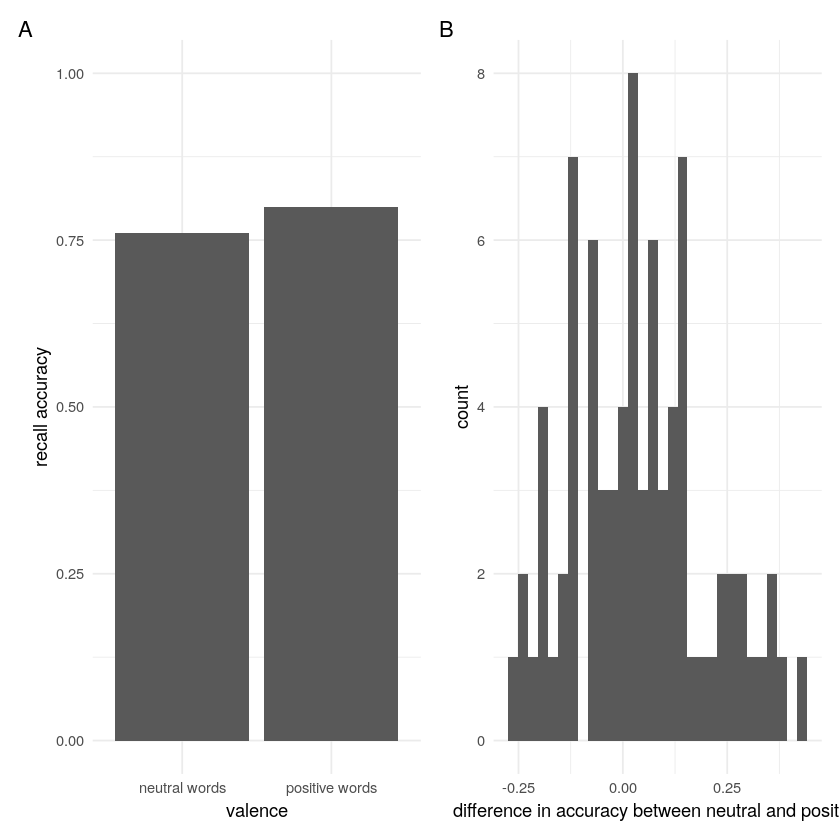

In [3]:
# lets take a look at the data

plot1 = ggplot(mapping = aes(x = c("neutral words","positive words"), y = c(netural_words,positive_words))) + 
geom_col() + theme_minimal() + scale_y_continuous(name = "recall accuracy", limits = c(0,1)) + 
scale_x_discrete(name = "valence")
plot2 = ggplot(mapping = (aes(x = g_m_2008_data))) + geom_histogram(bins = 30) + 
scale_x_continuous("difference in accuracy between neutral and positive") + theme_minimal()
plot1 + plot2 + plot_annotation(tag_levels = "A")

We'll now move on to the analysis. We'll do this in **3** steps. In step **1**, we'll just run a *t* test like Grider and Malmberg (2008) did. In step **2**, we'll run the **default Bayes factor** *t*-test using the **R** package developed Rouder et al. But so that we can **really** understand what's going on, in step **3**, we're going to calculate our own **Bayes factor** using the stuff we've learned up until now!

1. First do a *t* test and report the results!

In [4]:
# lets do some analysis!

# first, lets run a *t* test like Grider and Malmberg (2008)
t_test_results = t.test(g_m_2008_data)

# now we'll format them nicely!
t_test_results %>% tidy() %>% 
glue::glue_data("*t* ({parameter}) = {round(statistic,2)}, *p* = {round(p.value,2)}") %>%
IRdisplay::display_markdown()



*t* (79) = 2.24, *p* = 0.03

2. Now use the *store bought* **R** package

In [5]:
# now run a BF analysis with "default" priors

store_bought_bf  = BayesFactor::ttestBF(g_m_2008_data, rscale = 1)
store_bought_bf %>% tidy() %>% glue::glue_data("JZS Bayes factor = {round(BF01,2)}") %>% 
IRdisplay::display_markdown()

JZS Bayes factor = 1.02

3. Let's try figure out where that number comes from and what it means by reverse engineering it!

So far we've learned that we need 4 things to **build a BF**
1. we'll need to choose a **parameter** to make inferences about
2. We need a *likelihood function* which will describe how likely different **parameter** values are, given our data
3. We need a model of our Model 1 (we can call it $\mathcal{H}_0$)
4. We need a model of our Model 2 (we can call it $\mathcal{H}_1$)

What do Rouder et al have to say about **their** choices?

Rouder et al choose to make inferences about standardised effect sizes (e.g., $\delta$). This is probably a good choice, because standardised effect sizes are easily compared. However, raw effect (i.e., in milliseconds or percentages) are sometimes more *scientifically* meaningful. But we'll follow their choice. To calculate an 

We'll also need a likelihood function. The likelihood is going to describe the likely values of $\delta$ given our data. So the most likely value will be our observed effect size, and values $\delta$ will be less likely as we move away from this value. Unlike our coin flipping case it's pretty hard to do a simulation do derive the likelihood ourselves. But if we did, we'd see that it follows a *t* likelihood with *N - 1* degrees of freedom. This is what Rouder et al use. 

Next, we'll need a model of our *model 1* or *null hypothesis* (ie.,  $\mathcal{H}_0$). Following Rouder, we'll pick the hypothesis that $\delta$ = 0 as our $\mathcal{H}_0$. Up until now, we've only picked a single point for our model 1, but we don't need to. To define our model 1, we'll just say that for all values of $\delta \neq$ 0 will be weighted 0, and $\delta$ = 0 will be weighted 1. 

Finally, we need a model for our *model 2* or *alternative hypothesis* (i.e., $\mathcal{H}_1$). Here Rouder et al (2009) aim for a non-informative prior<sup>1</sup>. Their choice, it turns out, it a **Cauchy** distribution. They derive this by placing a **normal** prior on effect size where the variance of the normal is **inverse chi-square** distributed<sup>1</sup>. This mean that this prior is not characterising their beliefs about **reasonable** effect sizes. In fact, we'll see that it puts **a lot** of weight on completely unreasonable values that no scientific theory would predict. But that isn't there aim. They're trying to commit to as little as possible with their prior.

Now that we have all the bits we need, we can start building up our Bayes factor.


<sup>1</sup><small>Their exact model is slightly different, involving a prior on effect size and on the standard deviation, but we can ignore this complication for now. We'll make some of these choices explict when we build up more complex models like Rouder et al's model for two sample cases.</small>

The first step is our effect size parameter. This is calculated as the sample mean scaled by the sample standard deviation. That is: 
$$\delta=\frac{\mathrm{mean}}{\mathrm{sd}}$$

In [6]:
# calculate delta 

delta = mean(g_m_2008_data) / sd(g_m_2008_data)

glue::glue("The observed effect size is {round(delta,2)}") %>% IRdisplay::display_markdown()

The observed effect size is 0.25

The next step is our likelihood function. We'll define it with `t.lik` function from the **bayesplay** package. It's be centred at our $\delta$ valued and will have N - 1 degrees of freedom. It is used as follows:

```r
data_model = t.lik(center = ... , df = ...)

```

In [7]:
# Lets set up our likelihood
# we've already calculated the delta which will be the centre
# so we only need the number of data point

# calculate df
df = length(g_m_2008_data) - 1

# define liklihood 

data_model = t.lik(center = delta, df = df)
data_model


Object of class likelihood 
Likelihood type: non-central t 
Parameters
Center: 0.250439613479976
DF: 79

To help us get a better idea of the likelihood, we'll plot it. We'll also mark our observation, which should be the most likely parameter value. To plot the likelihood we just use the `plot()` function. As inputs, it takes the `likelihood` object and the range of $\delta$ values you want to plot over. E.g.:

```r 
plot(data_model, theta = seq(from = -1, to = 1,by = 0.001))
```

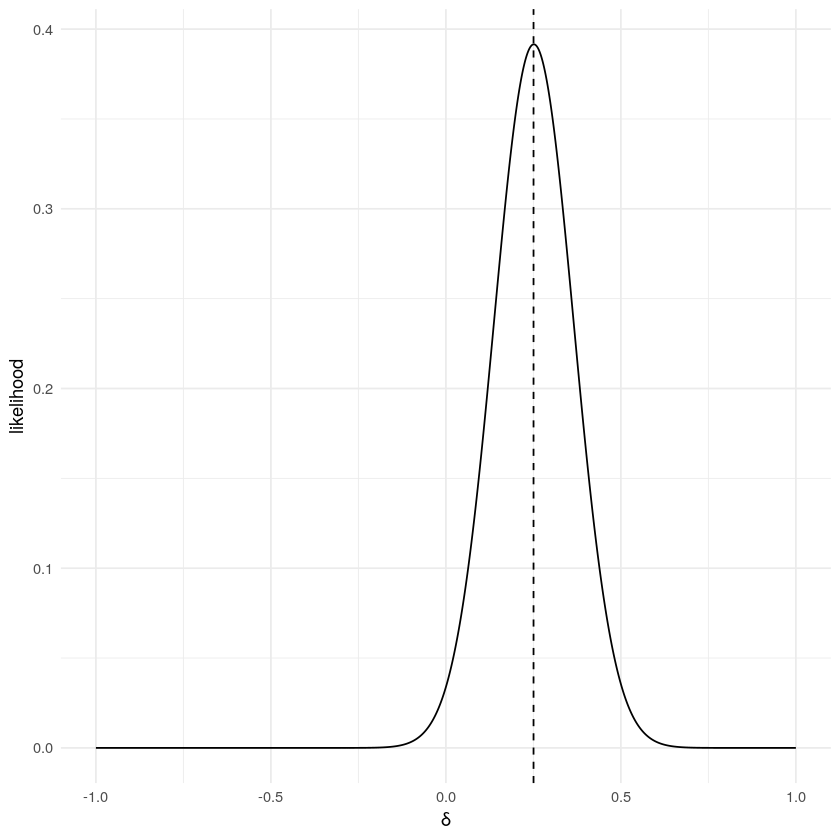

In [8]:
# Let's plot the likelihood function
# We'll make the plot and then style it with standard ggplot syntax

plot(data_model, theta = seq(from = -1, to = 1,by = 0.001)) + 
    scale_x_continuous(name = "δ") + 
    theme_minimal() + 
    geom_vline(xintercept = delta, linetype = 2)

Now that we have our likelihood's we'll need to define our two models. The syntax for defining models is a little clunky, but essentially we just need to give a weighting for every possible value of $\delta$. These should also (ideally) be proper probability distributions. That is, the area under their curves should be **1**. We don't have to worry about this at the moment, because we're using a proper probability distribution. In later analyses we will need to worry about it but luckily **bayesplay** automatically normalises priors so that they're proper. 

Most of our priors are either going to be **normal distributions**, **cauchy distributions**, **uniform distributions**, **t distibutions** or similar. Luckily **R** provides functions for these probability densities. They're are `dnorm()`, `dcauchy()`, `dunif()`, and `dt()` respectively. The basic structure of specifying a prior is as follows:

```r
prior = function(theta.range)
    {
    list(func = function(theta) PRIOR_FUNCTION,
         theta.range = theta.range)
    }
```

In [9]:
# we'll start by defining the null prior. 
# this is, for all values other than delta = 0, set the weight to 0, and when 
# delta = 0, set the weight to 1

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}

In [10]:
# now we define the "alternative" prior
# this will be a standard cauchy distribution

h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

We'll also plot our prior, so we can get an idea of what it looks like.

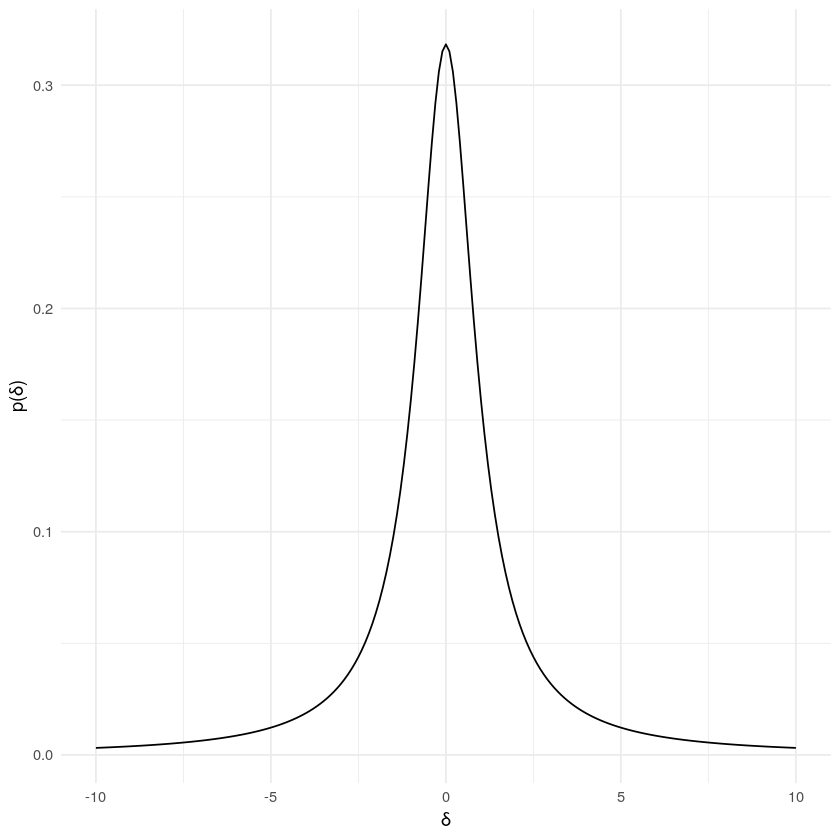

In [11]:
# plot the prior

# first set the range of values for the plot

theta.range = seq(-10,10,.1) # from -10 to +10 in steps 0.1

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_model(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "δ") + 
scale_y_continuous(name = "p(δ)") + theme_minimal()

As you can see there's still a fair bit of weight at values of $\delta\pm$ 5. But this isn't about Rouder et al's beliefs about reasonable effect sizes, so it's not a concern to them. 

Now that we have all the bits we need, we can work out the **Bayes factor**. We'll jump back to our formula: 

$$\mathcal{M}_H = \int_{\theta\in\Theta_H}\mathcal{L}_H(\theta|\mathbf{y})p(\theta)d\theta$$

This tells us that to make our the value for $\mathcal{M}_H$ we need to take the likelihood, multiply it by the prior, and then take the integral. And all this needs to be done of the *range* that the parameter takes. Effect sizes span the entire range of real numbers (i.e., $-\infty$ to $+\infty$) so that'll be our range for the alternative. For the null model, we're only interested in one value of $\delta$—when $\delta$ = 0. So we'll use the range (0,0) instead. 

To do this, we just use the following syntax:

```r
H_M = data_model * hm_model(theta.range = c(minval,maxval))
```




In [12]:
# multiple the prior and likelihood for H_0

M0 = data_model * h0_model(theta.range = c(0,0))
M0

Object of class posterior 
Parameter range: from  0  to  0 
Area under the curve (integral): 0.03386948 
Prior function:  function(theta) ifelse(theta == 0, 1, 0) 
Likelihood function:   

In [13]:
# multiple the prior and likelihood for H_0

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))
M1

Object of class posterior 
Parameter range: from  -Inf  to  Inf 
Area under the curve (integral): 0.033066 
Prior function:  function(theta) dcauchy(x = theta, location = 0, scale = 1) 
Likelihood function:   

Finally to work out the **Bayes factor** we just need to take the integral of model 1 and model 2, and then take the ratio of those values. 

To get the intergral of a model just use the following syntax:

```r
M_H$integral
```

In [14]:
BF01 = M0$integral / M1$integral
BF01

[1] 1.024299

Now let's compare our home made **BF** to the store bought version. 

In [15]:

glue::glue("The store bought **BF** using the **Bayes factor** package is {round(tidy(store_bought_bf)$BF01,2)}   
The one we made at home is {round(BF01,2)}") %>% IRdisplay::display_markdown()

The store bought **BF** using the **Bayes factor** package is 1.02   
The one we made at home is 1.02

We can put everything together in a single code block so it's easier to follow:

In [16]:
# calculate observed parameter value
delta = mean(g_m_2008_data) / sd(g_m_2008_data)

# define liklihood 
data_model = t.lik(center = delta, df = length(g_m_2008_data) - 1)

# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}


h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

# multiply the prior and likelihoods and priors

M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))

# take the intergral and divide

BF01 = M0$integral / M1$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 1.02

We can also work through the second example provided in Rouder et al (2009). Again, this deals with data from Grider and Malmberg (2008). This time, however, we'll work directly from the summary stats as an example. 

Rouder et al (2009) give the two condition means as 0.76 and 0.79, and they report the *t* statistic as 2.03. For the **Bayes factor**, they give a BF of $\frac{\mathcal{H}_0}{\mathcal{H}_1}$ of 1.56. 

In [17]:
# calculate observed parameter value
# effect sizes are just t / sqrt(N)
t_value = 2.03
N = 80
delta = t_value / sqrt(N)

# define liklihood 
data_model = t.lik(center = delta, df = N - 1)

# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0),
         theta.range = theta.range)
}


h1_model = function(theta.range){
    list(func = function(theta) dcauchy(x = theta, location = 0, scale = 1),
         theta.range = theta.range)
}

# multiply the prior and likelihoods

M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))

# take the intergral and divide

BF01 =  M0$integral / M1$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 1.56

Now that we're making our own **Bayes factors** we don't have to use the built in priors. We can make our own if we want to. Do you think Rouder et al's choices are reasonable? Do you have any other suggestions?

One possibility for an alternative prior is actually suggested by Rouder et al. They refer to it as the **unit information prior**. The unit information prior is just a standard normal distribution—that is, a normal distribution with a mean of 0 and a standard deviation of 1. That is, unlike the Cauchy, which doesn't commit to a single value of $\sigma$, the **unit information prior** sets $\sigma$ to 1. We'll set this prior up below, and we'll plot it.

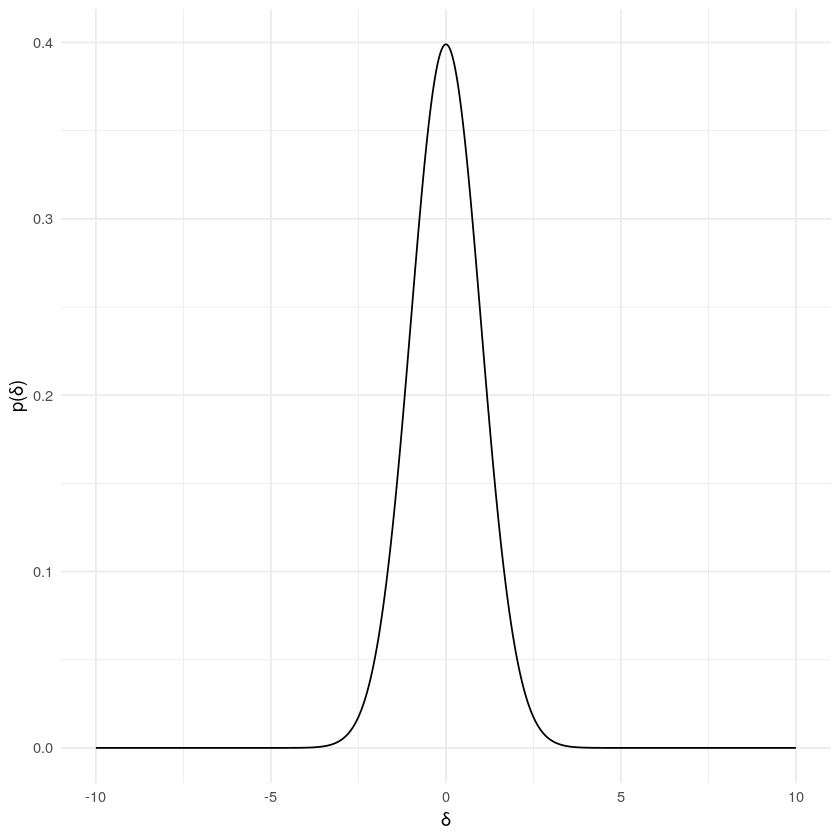

In [18]:

# define the prior

h1_unit_information = function(theta.range){
    list(func = function(theta) dnorm(x = theta, mean = 0, sd = 1),
         theta.range = theta.range)
}



# plot it over a reasonable range of theta
theta.range = seq(-10,10,.01) 

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_unit_information(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "δ") + 
scale_y_continuous(name = "p(δ)") + theme_minimal()

If you compare the plot above to the Cauchy prior you'll notice that the drop off is a lot steeper. This choice of prior seems to do a better job of actually reflecting our beliefs about the reasonable range of effect sizes in **psychology in general**. There's no appreciable mass at anything beyond 2.5, unlike the Cauchy which still had a lot of weight beyond 5.

Let's compute a **Bayes factor** using this new model. We don't have to re-specify the likelihood or the null model, because we'll just re-use everything from the previous example.

In [19]:
M1_unit_info = data_model * h1_unit_information(theta.range = c(-Inf, Inf))

BF01 =  M0$integral / M1_unit_info$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}") %>% IRdisplay::display_markdown()


B<sub>01</sub> = 1.21

We can see that the two priors yielded numerically different results. But they're not so different as to warrent different conclusions. We can try a range of **reasonable** priors to see how our conclusions change. 

But we can also try completely **unreasonable** priors. For example, Let's say that our alternative model consists of only a single value—the observed value. 

In [20]:
h1_psychic = function(theta.range){
    list(func = function(theta) ifelse(theta == delta, 1, 0) ,
         theta.range = theta.range)
}

M1_psychic = data_model * h1_psychic(theta.range = c(delta, delta))

BF01 =  M0$integral / M1_psychic$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 0.13

Or alternatively, we might set our alternative to equally weight all values of $\delta$ from -100 to +100. Again, this is completely unreasonable and it's just done as an illustration.

In [21]:
h1_uniform = function(theta.range){
    list(func = function(theta) dunif(x = theta, min = -100, max = 100) ,
         theta.range = theta.range)
}

M1_uniform = data_model * h1_uniform(theta.range = c(-100, 100))

BF01 =  M0$integral / M1_uniform$integral
glue::glue("B<sub>01</sub> = {round(BF01,2)}") %>% IRdisplay::display_markdown()

B<sub>01</sub> = 97.42

Rouder et al's approach is to place priors on **effect size**. Effect sizes might be an attract choice of parameterisation when we're trying to come up with priors that are *widely applicable*. But when we're thinking of *scientific theories* or *reasoning about effects*, it's often easier to do it in terms of **raw effects**—that is, what is the difference in *milliseconds* or in *accuracy*. Since we're building our own **BFs** we can build models for **raw effects** too. 

To explore this, we're going to look at a new examples from Dienes (2014, 2019). The models Dienes uses are parameterised in a simpler way than Rouder et al's model so they're applicable to one sample and two sample cases without modification. 

### Dienes (2014) Example 1

In [22]:
# to define the likelihood we'll need the mean and the standard error

negative_mood_acc = 65
positive_mood_acc = 70
mean_diff = abs(negative_mood_acc - positive_mood_acc)
t_stat = 0.5
se = mean_diff / t_stat

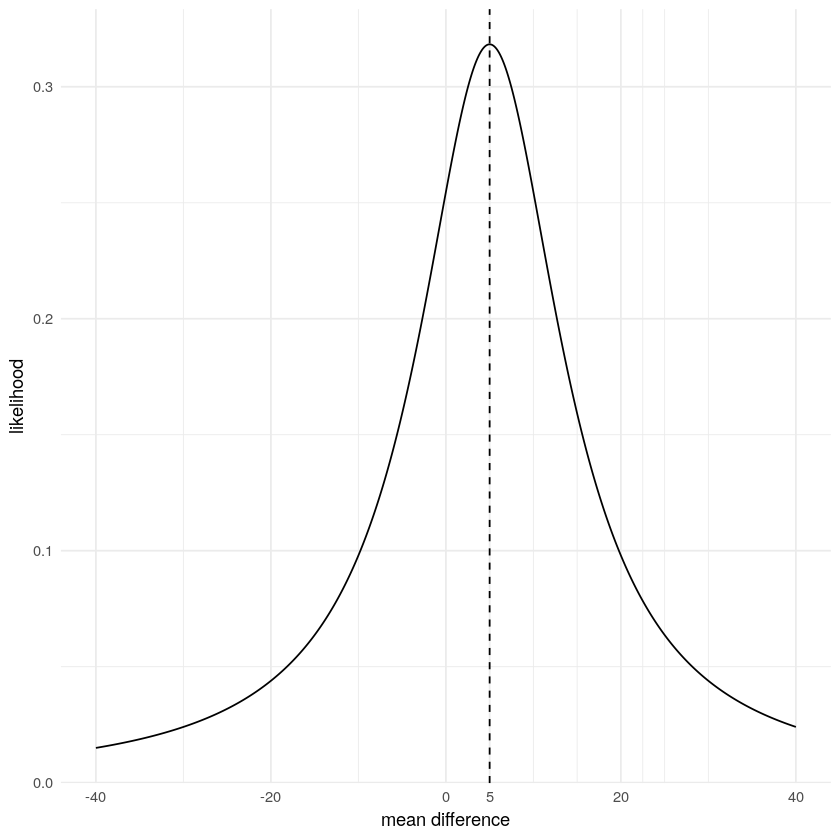

In [23]:
# define the likelihood
# we'll use a normal likelihood
# using a normal might not be the *best* choice, but we'll use it because Dienes (2014) uses a normal
# we can discuss alternatives in subsequent examples

#data_model = norm.lik(center = mean_diff, scale =  se)
data_model = scaled.shifted.t.lik(center = mean_diff, scale =  se, df = 1)


plot(data_model, theta = seq(-40,40,.1)) + geom_vline(xintercept = mean_diff, linetype = 2) + 
scale_x_continuous(name = "mean difference", breaks = c(seq(-40,40,20),mean_diff)) + theme_minimal()

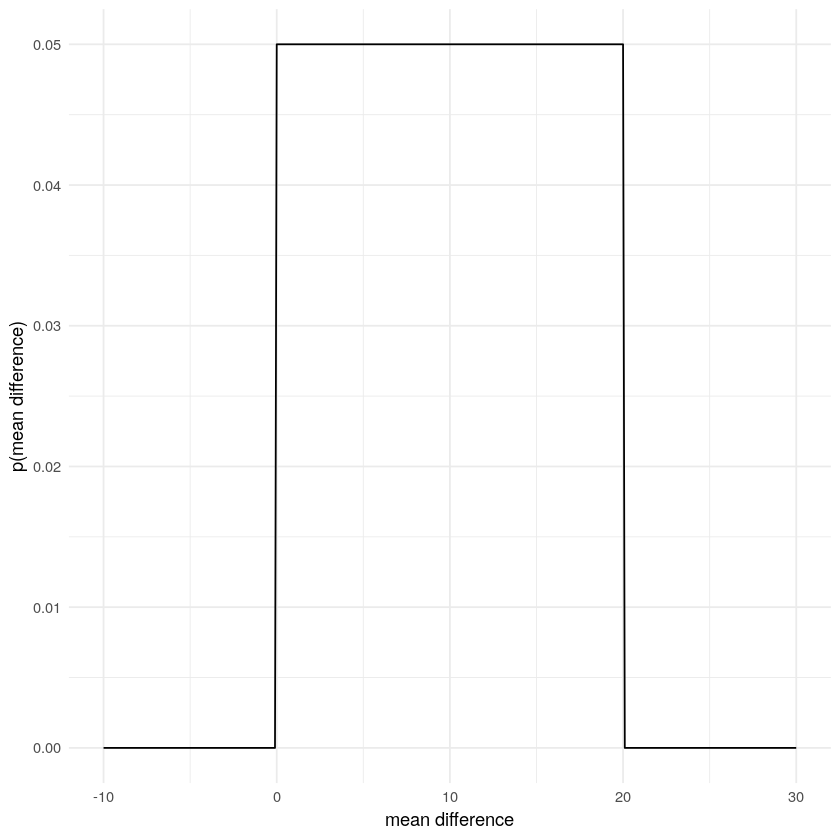

In [24]:
# define model / priors

h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0), # a point null with mean diff = 0
         theta.range = theta.range)
}

h1_model = function(theta.range){
    list(func = function(theta) dunif(x = theta, min = 0, max = 20), # uniform prior from 0 to 20
         theta.range = theta.range)
}

# plot the h1 prior 

theta.range = seq(-10,30,.1) # from -10 to +30 in steps 0.1

# then make a tibble with the data for the plot
tibble(theta = theta.range, p = h1_model(theta.range)$func(theta.range)) %>% 
ggplot(aes(x = theta, y = p)) + geom_line() + scale_x_continuous(name = "mean difference") + 
scale_y_continuous(name = "p(mean difference)") + theme_minimal()


In [25]:
# multiply the prior and likelihoods and priors
M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(-Inf, Inf))


BF10 = M1$integral / M0$integral
glue::glue("B<sub>10</sub> = {round(BF10,2)}") %>% IRdisplay::display_markdown()

B<sub>10</sub> = 0.9

Dienes extends the example a bit to show how **BFs** and *p*-values will sometimes lead to different conclusions. It's worth examing the example to understand why this is the case. It'll help us understand both **BFs** and *p*-values better. 

Dienes asks to consider two examples:

1. A mean difference of 1 with a standard error of 10
2. A mean difference of 1 with a standard error of 1

He goes on to calculate *p* values and **BFs** (using the above model<sup>1</sup>) for both example. We'll do the same, and examine the results. 


<sup>1</sup><small>A key point here is that the exact same priors are used for both examples. We might want to question whether this is reasonable.</small>

In [26]:
# Example 1 (t test)

mean_diff = 1
se.1 = 10
df = 50
t_stat.1 = mean_diff / se.1
p_value.1 = 2 * pt(t_stat.1, df,lower.tail = F)

glue::glue("For Example 1, a standard *t* test gives the result: *t*({df}) = {round(t_stat.1,2)}, 
*p* = {round(p_value.1,2)}") %>% 
IRdisplay::display_markdown()

For Example 1, a standard *t* test gives the result: *t*(50) = 0.1, 
*p* = 0.92

In [27]:
# Example 1 with BFs

# We'll use the same priors as before so we just have to change the likelihood (aka data mode)

data_model.1 = norm.lik(center = mean_diff, scale =  se.1)

M0 = data_model.1 * h0_model(theta.range = c(0,0))

M1 = data_model.1 * h1_model(theta.range = c(-Inf, Inf))
BF01.1 = M0$integral / M1$integral
glue::glue("For example 1, the BF analysis gives B<sub>01</sub> = {round(BF01.1,2)}") %>%
IRdisplay::display_markdown()


For example 1, the BF analysis gives B<sub>01</sub> = 1.55

In [28]:
# Example 2 (t test)

mean_diff = 1
se.2 = 1
df = 50
t_stat.2 = mean_diff / se.2
p_value.2 = 2 * pt(t_stat.2, df,lower.tail = F)

glue::glue("For Example 2, a standard *t* test gives the result: *t*({df}) = {round(t_stat.2,2)}, 
*p* = {round(p_value.2,2)}") %>% 
IRdisplay::display_markdown()

For Example 2, a standard *t* test gives the result: *t*(50) = 1, 
*p* = 0.32

In [29]:
# Example 2 with BFs

# We'll use the same priors as before so we just have to change the likelihood (aka data mode)

data_model.2 = norm.lik(center = mean_diff, scale =  se.2)

M0 = data_model.2 * h0_model(theta.range = c(0,0))

M1 = data_model.2 * h1_model(theta.range = c(-Inf, Inf))
BF01.2 = M0$integral / M1$integral
glue::glue("For example 2, the BF analysis gives B<sub>10</sub> = {round(BF01.2,2)}") %>%
IRdisplay::display_markdown()


For example 2, the BF analysis gives B<sub>10</sub> = 5.75

Understanding the difference between these two inferences highlights how the two kinds of analysis ask different questions. Remember, *p* values ask about whether **data are surprising** given a particular parameter. In contrast, **BFs** ask about **plausible values of a parameter**. We can highlight this different by plotting, on the same figure, the range of **unsurprising** data values and the **likely values of the parameter** given our data.

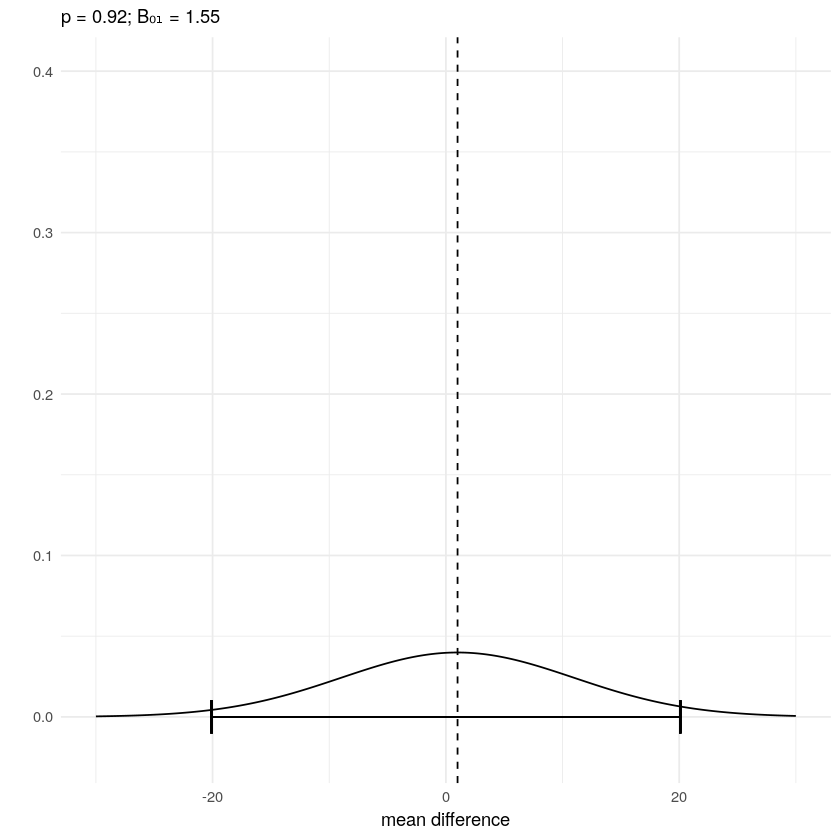

In [30]:
# Example 1

# First get the unsurprising range of data values

# work out the range of unsurprising values in t units
t_range.1 = qt(.975, df = 50, ncp = 0)

# unscale this so that it's in original units
mean_range.1 = t_range.1 * se.1

plot(data_model.1, theta = seq(-30,30,.1)) + ylim(c(-.02,.4)) +
geom_errorbarh(mapping = aes(xmin = -mean_range.1, xmax = mean_range.1, y = 0), height = .02) + 
geom_vline(xintercept = mean_diff, linetype = 2 ) + theme_minimal() +
labs(subtitle = glue::glue("p = {round(p_value.1,2)}; B₀₁ = {round(BF01.1,2)}"), x = "mean difference", y = "")

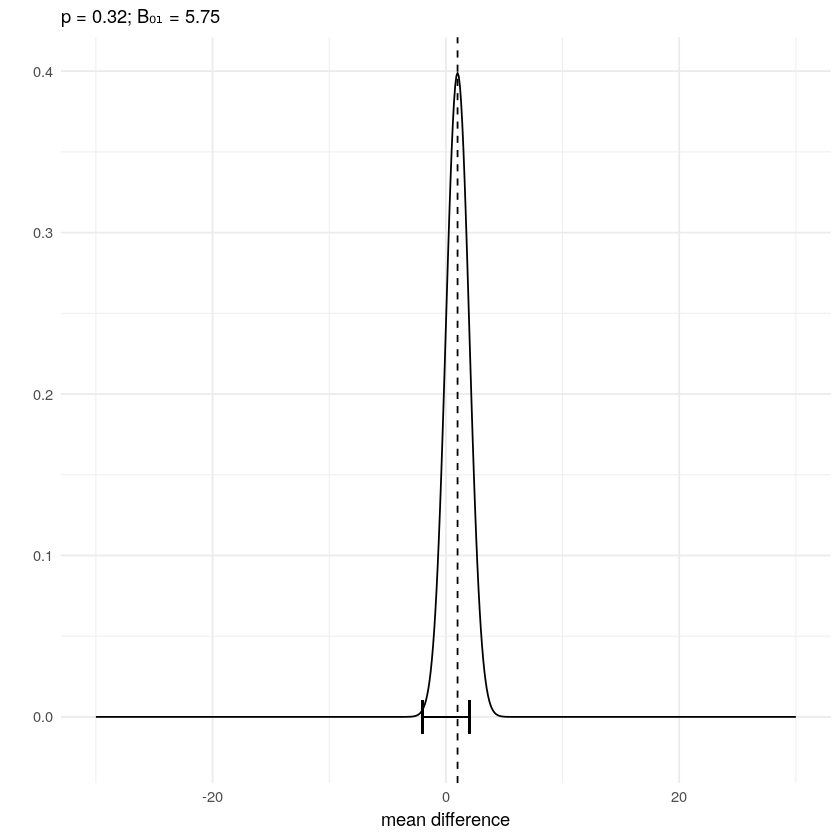

In [31]:
# Example 2

# First get the unsurprising range of data values

# work out the range of unsurprising values in t units
t_range.2 = qt(.975, df = 50, ncp = 0)

# unscale this so that it's in original units
mean_range.2 = t_range.2 * se.2

plot(data_model.2, theta = seq(-30,30,.1))  + ylim(c(-.02,.4)) +
geom_errorbarh(mapping = aes(xmin = -mean_range.2, xmax = mean_range.2, y = 0), height = .02) + 
geom_vline(xintercept = mean_diff, linetype = 2 ) + theme_minimal()  +
labs(subtitle = glue::glue("p = {round(p_value.2,2)}; B₀₁ = {round(BF01.2,2)}"), x = "mean difference", y = "")

In the plots we can see that in example 1, a very wide range of values of the mean difference could plausibly produce the value of the mean difference we actually observed. In example 2, however, the range of plausible values for the mean difference is very small. In example 1, the range of values includes values that are both very big and very small. That is, data show that we're very uncertain about the actual value of the mean difference with the likelihood being wide and spread out; therefore, the BF value does allow us to make any strong conclusions either way about which model is best supported. In example 2, however, the range is narrow and all the values are very close to 0 (our null value)—that is, the likelihood is highly peaked near 0.

The frequentist inference asks something completely different. We set the paramter to 0, and then generate data based on this. We compare this generated data with our actual data and ask if it's surprising or not. From the first plot, we see that the "unsurprising" range is very large. Our data lies somewhere near the middle of the range. In the second figure, the range is very narrow. As a result, our data now lies right near the edge of the range. 

Again, because this is not a class on frequentist inference I won't give details on what I think the **correct** frequentist analysis for these example should be. But these examples are illustrative because they employ the **common** way **most people** would analyse this kind data.